In [127]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import matplotlib 
matplotlib.rc('xtick', labelsize=10) 
matplotlib.rc('ytick', labelsize=10)
matplotlib.rcParams.update({'font.size': 20})
import pandas as pd
from virgodb import VirgoDB
vdb = VirgoDB("giorgio",password="BN401kmd")
import time

from fase.fileio import Table

# COSMOLOGY

In [3]:
def integ_trap(func,z1,z2,N=1000):
    z = np.logspace(np.log10(z1),np.log10(z2),N)
    y = func(z)

    A = 0
    for i in range(len(z)-1):
        A += np.abs((z[i+1]-z[i]))*(y[i]+y[i+1])/2
    return A

def E(z,Om_rad=8.4*10**(-5),Om_lambda=0.7,Om_mat=0.3):
    return np.sqrt(Om_rad*(1+z)**4 + Om_mat*(1+z)**3 + Om_lambda)

def over_E(z):
    return E(z)**(-1)

def comoving_distance(z):
    zero = 10**(-20)
    c = 3e5 #km/s
    H0=100. #km/s/Mpc
    return (c*H0**(-1)*integ_trap(over_E,zero,z,10**(3))) #Mpc h^-1

vec_r = np.vectorize(comoving_distance)

def Luminosity_distance(z):
    '''Returns the Luminosity distance in units of Mpc h^-1'''
    return comoving_distance(z)*(1.+z)

def ABSOLUTE_MAGNITUDE_minus5logh(m,z,K_correction=False,ratio_L=1.):
    if K_correction:
        return m -25. -5.*np.log10(Luminosity_distance(z)) -2.5*np.log10(ratio_L*(1.+z))
    else:
        return m -25. -5.*np.log10(Luminosity_distance(z))

vec_ABSOLUTE_MAGNITUDE_minus5logh = np.vectorize(ABSOLUTE_MAGNITUDE_minus5logh)

# EDGE

In [4]:
def EDGE(x,y,x_min=-26.,x_max=-15.,x_bin_size=0.1,y_min=0.55,y_max=2.1,y_bin_size=0.15,threashold =0.15):
    '''It returns two arrays containing the x and y of the edge'''
    y_Nbins = int((y_max - y_min) / y_bin_size)
    x_Nbins = int((x_max - x_min) / x_bin_size)
    x_edge=[]
    y_edge=[]
    #loop on y bins
    for i in range(y_Nbins):
        # define y bin
        y_low = y_min + y_bin_size * i
        y_high = y_min + y_bin_size * (i+1)
        y_center = (y_low+y_high)/2.
        select_y_in_ybin = np.where((y>=y_low)&(y<y_high))
        # histogram of x in a selected y bin
        x_histo, x_histo_bins = np.histogram(x[select_y_in_ybin],bins=x_Nbins,range=(x_min,x_max))
        #find most populated bin
        x_histo_max = np.max(x_histo[:-1])
        x_histo_max_index = np.argmax(x_histo[:-1])
        #loop to find the edge
        for j in range(x_histo_max_index,0,-1):
            if (x_histo[j]<x_histo_max * threashold):
                edge_index = j
                break
        x_edge.append(x_histo_bins[j])
        y_edge.append(y_center)
    return np.array(x_edge), np.array(y_edge)

# QUERY

In [6]:
QJ = 'SELECT '
QJ += '   des.mag_V_ext as d_mag_V_ext, '
QJ += '   des.SDSS_u_ext as d_SDSS_u_ext, '
QJ += '   prog.mag_V_ext as p_mag_V_ext, '
QJ += '   prog.SDSS_u_ext as p_SDSS_u_ext, ' 
QJ += '   prog.stellarmass as p_stellarmass, '
QJ += '   des.stellarmass as d_stellarmass, '
QJ += '   des.SDSS_i_obs_ext as d_SDSS_i_obs_ext, '
QJ += '   prog.SDSS_i_obs_ext as p_SDSS_i_obs_ext '
QJ += 'FROM '
QJ += '   Gonzalez2014a..mr7 as des with(index(pk_mr7_galaxyid)), '
QJ += '   Gonzalez2014a..mr7 as prog with(forceseek,index(pk_mr7_galaxyid)) '
QJ += 'WHERE '
QJ += '   des.snapnum = 47 AND '
QJ += '   prog.galaxyid BETWEEN des.galaxyid AND des.mainleafid '
QJ += '   AND prog.snapnum = 37 '
QJ += '   AND des.stellarmass>0.1 '

t1 = time.time()
vdb.query_to_file("../data/prog_37_47_JohnHelly_0.txt", QJ, format="text")
t2 = time.time()

1399.34540987


In [11]:
print "Query time = ",(t2-t1)/60,"minutes"

Query time =  23.3224234978 minutes


# Read from file

In [5]:
john_0 = pd.read_csv("../data/prog_37_47_JohnHelly_0.txt",comment='#',delimiter=',')

In [11]:
print 'Names  :', john_0.columns.values
print 'Length :',len(john_0)

Names  : ['d_mag_V_ext' 'd_SDSS_u_ext' 'p_mag_V_ext' 'p_SDSS_u_ext' 'p_stellarmass'
 'd_stellarmass' 'd_SDSS_i_obs_ext' 'p_SDSS_i_obs_ext']
Length : 3857651


# COLOUR MAGNITUDE

## Variables

In [27]:
#cut of the descendants (z~0.46) at i<22.5 
CUT_225_d = np.where(john_0['d_SDSS_i_obs_ext']<ABSOLUTE_MAGNITUDE_minus5logh(22.5,0.46))
#cut of the progenitors (z~1.17) at i<22.5 
CUT_225_p = np.where(john_0['p_SDSS_i_obs_ext']<ABSOLUTE_MAGNITUDE_minus5logh(22.5,1.17))

print "ABSOLUTE MAGNITUDE OF m=22.5 at z ~ 0.46: ",round((ABSOLUTE_MAGNITUDE_minus5logh(22.5,0.46)),2)
print "ABSOLUTE MAGNITUDE OF m=22.5 at z ~ 1.17: ",round((ABSOLUTE_MAGNITUDE_minus5logh(22.5,1.17)),2)

xp = np.array(john_0['p_mag_V_ext'])[CUT_225_p]
yp = np.array(john_0['p_SDSS_u_ext'])[CUT_225_p]-np.array(john_0['p_mag_V_ext'])[CUT_225_p]

xd = np.array(john_0['d_mag_V_ext'])[CUT_225_d]
yd = np.array(john_0['d_SDSS_u_ext'])[CUT_225_d]-np.array(john_0['d_mag_V_ext'])[CUT_225_d]


ABSOLUTE MAGNITUDE OF m=22.5 at z ~ 0.46:  -18.77
ABSOLUTE MAGNITUDE OF m=22.5 at z ~ 1.17:  -21.25


## Define the edge

In [72]:
xd_edge,yd_edge = EDGE(xd,yd,y_min=0.,y_max=2.2,y_bin_size=0.06,threashold=0.02)
xp_edge,yp_edge = EDGE(xp,yp,y_min=0.,y_max=2.2,y_bin_size=0.06,threashold=0.02)

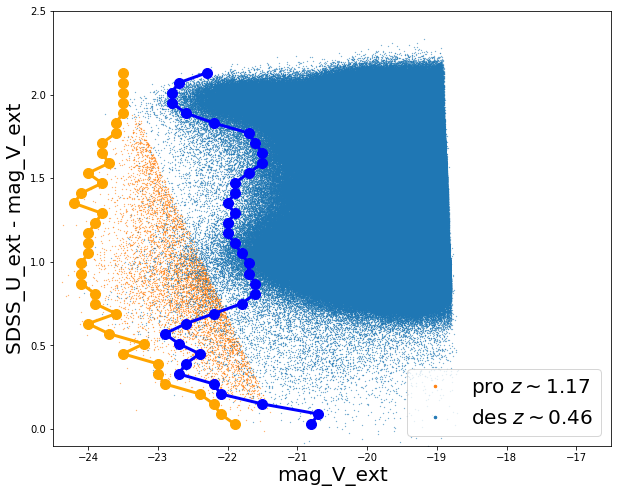

In [74]:
plt.figure(figsize=(10,8))

#points
plt.plot(xp,yp,".",markersize=0.5,label=r'pro $z\sim1.17$',c='C1')
plt.plot(xd,yd,".",markersize=0.5,label=r'des $z\sim0.46$',c='C0')

#edges
plt.plot(xp_edge,yp_edge,".",markersize=20,c='orange')
plt.plot(xp_edge,yp_edge,"-",lw=3,c='orange')
plt.plot(xd_edge,yd_edge,".",markersize=20,c='blue')
plt.plot(xd_edge,yd_edge,"-",lw=3,c='blue')

#labels
plt.xlabel("mag_V_ext")
plt.ylabel("SDSS_U_ext - mag_V_ext")
plt.legend(markerscale=10)

#limits
plt.xlim(-24.5,-16.5)
plt.ylim(-0.1,2.5)

plt.savefig("../plots/009/col_mag_des_prog_cut225_edge_002thr.png")
plt.show()

# Plot histograms of magnitudes per colour bin

In [66]:
def HISTO(x,y,x_min=-26.,x_max=-15.,x_bin_size=0.1,y_min=0.55,y_max=2.1,y_bin_size=0.15,threashold =0.15,save=True):

    plt.figure(figsize=(10,8))
    
    y_Nbins = int((y_max - y_min) / y_bin_size)
    x_Nbins = int((x_max - x_min) / x_bin_size)
    x_edge=[]
    y_edge=[]
    #loop on y bins
    for i in range(y_Nbins):
        # define y bin
        y_low = y_min + y_bin_size * i
        y_high = y_min + y_bin_size * (i+1)
        y_center = (y_low+y_high)/2.
        select_y_in_ybin = np.where((y>=y_low)&(y<y_high))
        # histogram of x in a selected y bin
        #x_histo, x_histo_bins = np.histogram(x[select_y_in_ybin],bins=x_Nbins,range=(x_min,x_max))
        plt.hist(x[select_y_in_ybin],bins=x_Nbins,range=(x_min,x_max),histtype='bar',lw=3)
        if save:
            plt.savefig('../plots/009/histo/'+str(int(y_center*100))+".png")
    plt.ylabel("counts")
    plt.xlabel("mag_V_ext")
    plt.savefig('../plots/009/histo_mags_per_colour.png')
    plt.show()
        #find most populated bin
        #x_histo_max = np.max(x_histo[:-1])
        #x_histo_max_index = np.argmax(x_histo[:-1])
        #loop to find the edge
        #for j in range(x_histo_max_index,0,-1):
        #    if (x_histo[j]<x_histo_max * threashold):
        #        edge_index = j
        #        break
        #x_edge.append(x_histo_bins[j])
        #y_edge.append(y_center)
    #return np.array(x_edge), np.array(y_edge)

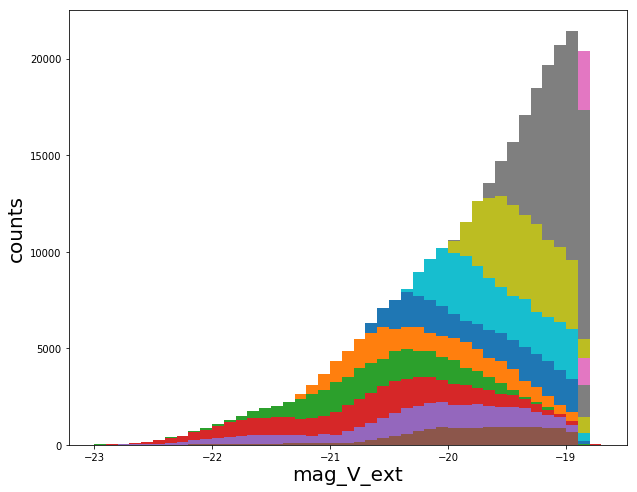

In [67]:
HISTO(xd,yd,y_min=0.,y_max=2.2,y_bin_size=0.06,x_min=-23.,x_max=-18.7)

# Draw contours

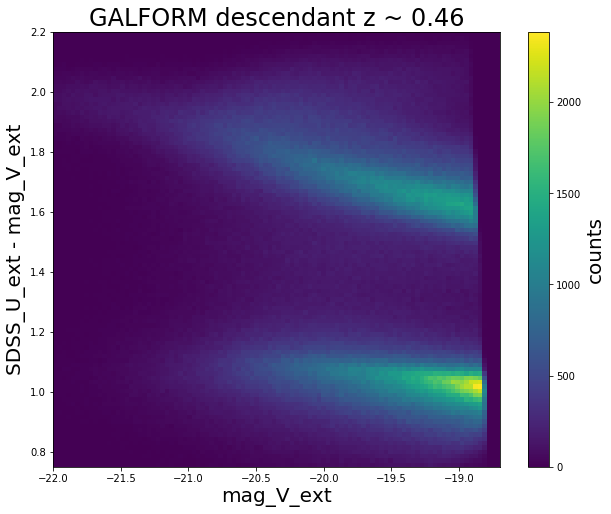

In [193]:
plt.figure(figsize=(10,8))
plt.hist2d(xd,yd,bins=100,range=[[-22,-18.7],[0.75,2.2]])
plt.colorbar(label='counts')
plt.title('GALFORM descendant z ~ 0.46')
plt.xlabel("mag_V_ext")
plt.ylabel("SDSS_U_ext - mag_V_ext")
plt.show()

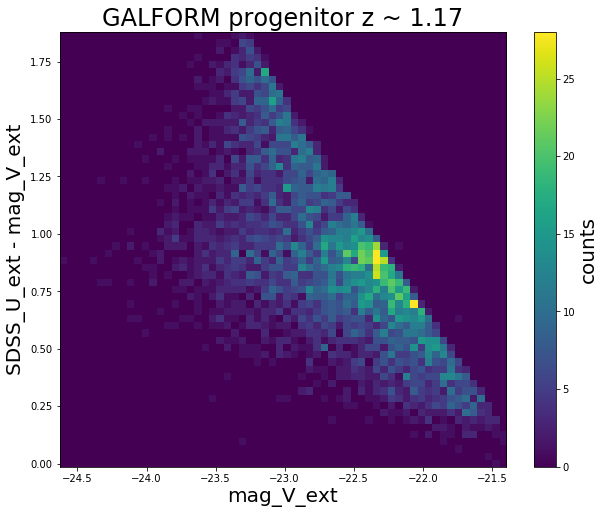

In [212]:
plt.figure(figsize=(10,8))
plt.hist2d(xp,yp,bins=60)#,range=[[-22,-18.7],[0.75,2.2]])
plt.colorbar(label='counts')
plt.title('GALFORM progenitor z ~ 1.17')
plt.xlabel("mag_V_ext")
plt.ylabel("SDSS_U_ext - mag_V_ext")
plt.show()

In [207]:
counts_des,x_edges_des,y_edges_des = np.histogram2d(xd,yd,bins=100,range=[[-22,-18.7],[0.75,2.2]])

In [208]:
X_des,Y_des = np.meshgrid(x_edges_des[:-1],y_edges_des[:-1]) 
# Actually it works also without meshgrid but this is the right thing to do

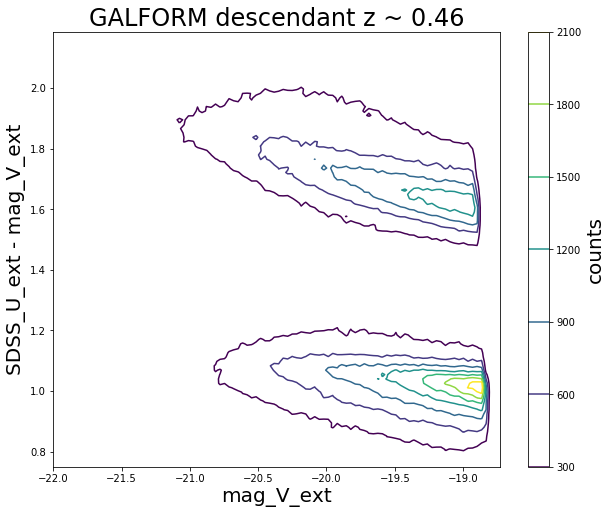

In [209]:
plt.figure(figsize=(10,8))
plt.contour(X_des,Y_des,counts_des.T) # Remember to transpose!!!!!!!!!!! 
#plt.contour(x_edges[:-1],y_edges[:-1],counts.T)
plt.title('GALFORM descendant z ~ 0.46')
plt.xlabel("mag_V_ext")
plt.ylabel("SDSS_U_ext - mag_V_ext")
plt.colorbar(label='counts')
plt.show()

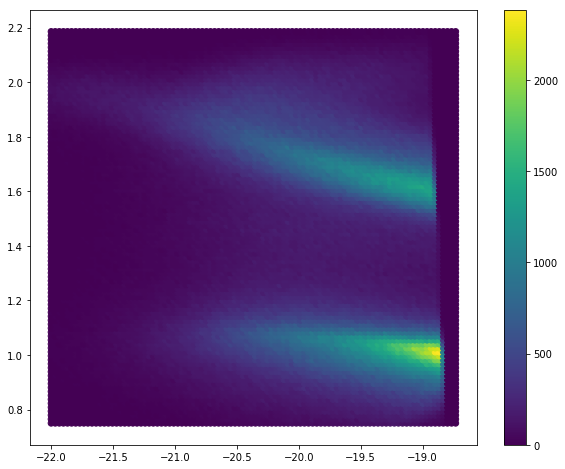

In [210]:
plt.figure(figsize=(10,8))
plt.scatter(X_des,Y_des,c=counts_des.T) # Remember to transpose the output of histo2d (counts)!!!!
plt.colorbar()
plt.show()

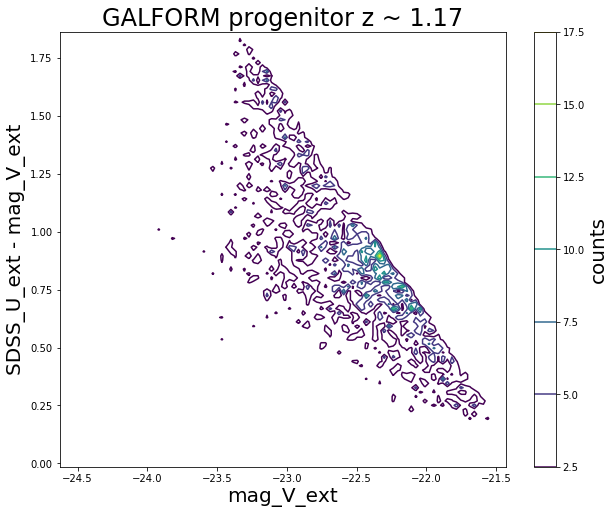

In [211]:
counts_pro,x_edges_pro,y_edges_pro = np.histogram2d(xp,yp,bins=100)
X_pro,Y_pro = np.meshgrid(x_edges_pro[:-1],y_edges_pro[:-1]) 
plt.figure(figsize=(10,8))
plt.contour(X_pro,Y_pro,counts_pro.T) # Remember to transpose!!!!!!!!!!! 
#plt.contour(x_edges[:-1],y_edges[:-1],counts.T)
plt.title('GALFORM progenitor z ~ 1.17')
plt.xlabel("mag_V_ext")
plt.ylabel("SDSS_U_ext - mag_V_ext")
plt.colorbar(label='counts')
plt.show()

# Read VIPERS

In [128]:
VIPERS = Table("../../Data_Sample_V7.fits",hdu=8)

In [130]:
U_vip = VIPERS.getCol("M_Uj")
V_vip = VIPERS.getCol("M_V")
UV_vip =U_vip-V_vip

z_vip = VIPERS.getCol("zspec_1")

z_low_vip= np.where((z_vip>=0.4)&(z_vip<0.5))
z_hig_vip= np.where((z_vip>=1.0)&(z_vip<1.3))

xedge_vip_zlow,yedge_vip_zlow= EDGE(V_vip[z_low_vip],UV_vip[z_low_vip],x_min=-25,x_max=-18,y_min=0.2,y_max=2.4)
xedge_vip_zhigh,yedge_vip_zhigh= EDGE(V_vip[z_hig_vip],UV_vip[z_hig_vip],x_min=-25,x_max=-18,y_min=0.2,y_max=2.4)

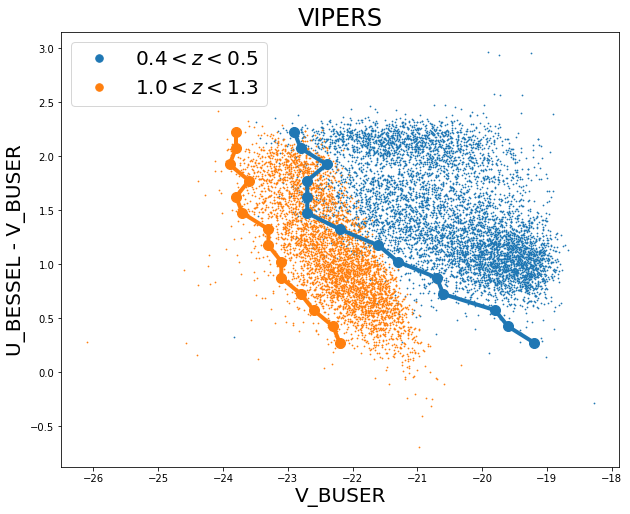

In [131]:
plt.figure(figsize=(10,8))
plt.plot(V_vip[z_low_vip],UV_vip[z_low_vip],".",markersize=1.5,color='C0',label=r'$0.4<z<0.5$')
plt.plot(V_vip[z_hig_vip],UV_vip[z_hig_vip],".",markersize=1.5,color='C1',label=r'$1.0<z<1.3$')
plt.plot(xedge_vip_zlow,yedge_vip_zlow,"-",lw=4,color='C0')
plt.plot(xedge_vip_zhigh,yedge_vip_zhigh,"-",lw=4,color='C1')
plt.plot(xedge_vip_zlow,yedge_vip_zlow,".",lw=4,color='C0',markersize=20)
plt.plot(xedge_vip_zhigh,yedge_vip_zhigh,".",lw=4,color='C1',markersize=20)
plt.legend(markerscale=10)
plt.xlabel("V_BUSER")
plt.ylabel("U_BESSEL - V_BUSER")
plt.title('VIPERS')
#plt.savefig('../plots/008/bright_edge_VIPERS.png')
plt.show()

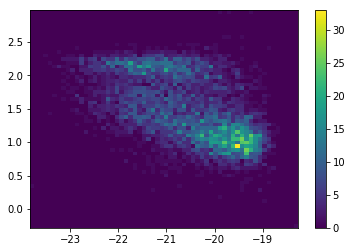

In [185]:
plt.hist2d(V_vip[z_low_vip],UV_vip[z_low_vip],bins=60)
plt.colorbar()
plt.show()

In [186]:
counts_vip_zl,x_edges_vip_zl,y_edges_vip_zl =np.histogram2d(V_vip[z_low_vip],UV_vip[z_low_vip],bins=60)

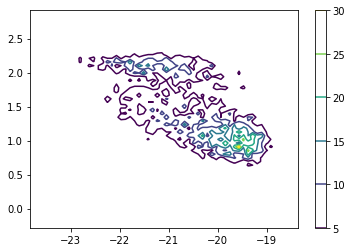

In [187]:
plt.contour(x_edges_vip_zl[:-1],y_edges_vip_zl[:-1],counts_vip_zl.T)
plt.colorbar()
plt.show()

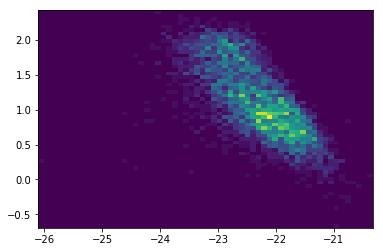

In [189]:
plt.hist2d(V_vip[z_hig_vip],UV_vip[z_hig_vip],bins=60)
counts_vip_zh,x_edges_vip_zh,y_edges_vip_zh =np.histogram2d(V_vip[z_hig_vip],UV_vip[z_hig_vip],bins=60)
plt.show()

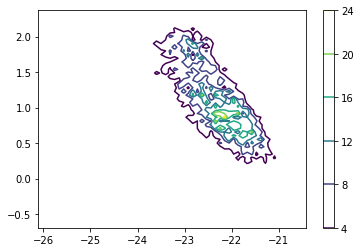

In [190]:
plt.contour(x_edges_vip_zh[:-1],y_edges_vip_zh[:-1],counts_vip_zh.T)
plt.colorbar()
plt.show()